In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

In [2]:
train_data_path = '/kaggle/input/age-detection-human-faces-18-60-years/train'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [3]:
train_df

filepaths  label
0    /kaggle/input/age-detection-human-faces-18-60-...  51-60
1    /kaggle/input/age-detection-human-faces-18-60-...  51-60
2    /kaggle/input/age-detection-human-faces-18-60-...  51-60
3    /kaggle/input/age-detection-human-faces-18-60-...  51-60
4    /kaggle/input/age-detection-human-faces-18-60-...  51-60
..                                                 ...    ...
120  /kaggle/input/age-detection-human-faces-18-60-...  41-50
121  /kaggle/input/age-detection-human-faces-18-60-...  41-50
122  /kaggle/input/age-detection-human-faces-18-60-...  41-50
123  /kaggle/input/age-detection-human-faces-18-60-...  41-50
124  /kaggle/input/age-detection-human-faces-18-60-...  41-50

[125 rows x 2 columns]

In [4]:
test_data_path = '/kaggle/input/age-detection-human-faces-18-60-years/test'
filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [5]:
test_df

filepaths  label
0   /kaggle/input/age-detection-human-faces-18-60-...  51-60
1   /kaggle/input/age-detection-human-faces-18-60-...  51-60
2   /kaggle/input/age-detection-human-faces-18-60-...  51-60
3   /kaggle/input/age-detection-human-faces-18-60-...  51-60
4   /kaggle/input/age-detection-human-faces-18-60-...  51-60
5   /kaggle/input/age-detection-human-faces-18-60-...  31-40
6   /kaggle/input/age-detection-human-faces-18-60-...  31-40
7   /kaggle/input/age-detection-human-faces-18-60-...  31-40
8   /kaggle/input/age-detection-human-faces-18-60-...  31-40
9   /kaggle/input/age-detection-human-faces-18-60-...  31-40
10  /kaggle/input/age-detection-human-faces-18-60-...  21-30
11  /kaggle/input/age-detection-human-faces-18-60-...  21-30
12  /kaggle/input/age-detection-human-faces-18-60-...  21-30
13  /kaggle/input/age-detection-human-faces-18-60-...  21-30
14  /kaggle/input/age-detection-human-faces-18-60-...  21-30
15  /kaggle/input/age-detection-human-faces-18-60-...  18-20
16  /kaggle/input/age-detection-human-faces-18-60-...  18-20
17  /kaggle/input/age-detection-human-faces-18-60-...  18-20
18  /kaggle/input/age-detection-human-faces-18-60-...  18-20
19  /kaggle/input/age-detection-human-faces-18-60-...  18-20
20  /kaggle/input/age-detection-human-faces-18-60-...  41-50
21  /kaggle/input/age-detection-human-faces-18-60-...  41-50
22  /kaggle/input/age-detection-human-faces-18-60-...  41-50
23  /kaggle/input/age-detection-human-faces-18-60-...  41-50
24  /kaggle/input/age-detection-human-faces-18-60-...  41-50

In [6]:
valid,test = train_test_split(test_df,train_size=0.5,shuffle=True,random_state=101)

**Image Data Generator**

In [7]:
img_size = (224 ,224)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 125 validated image filenames belonging to 5 classes.
Found 12 validated image filenames belonging to 5 classes.
Found 13 validated image filenames belonging to 5 classes.


**Sample Data From Train Directory**

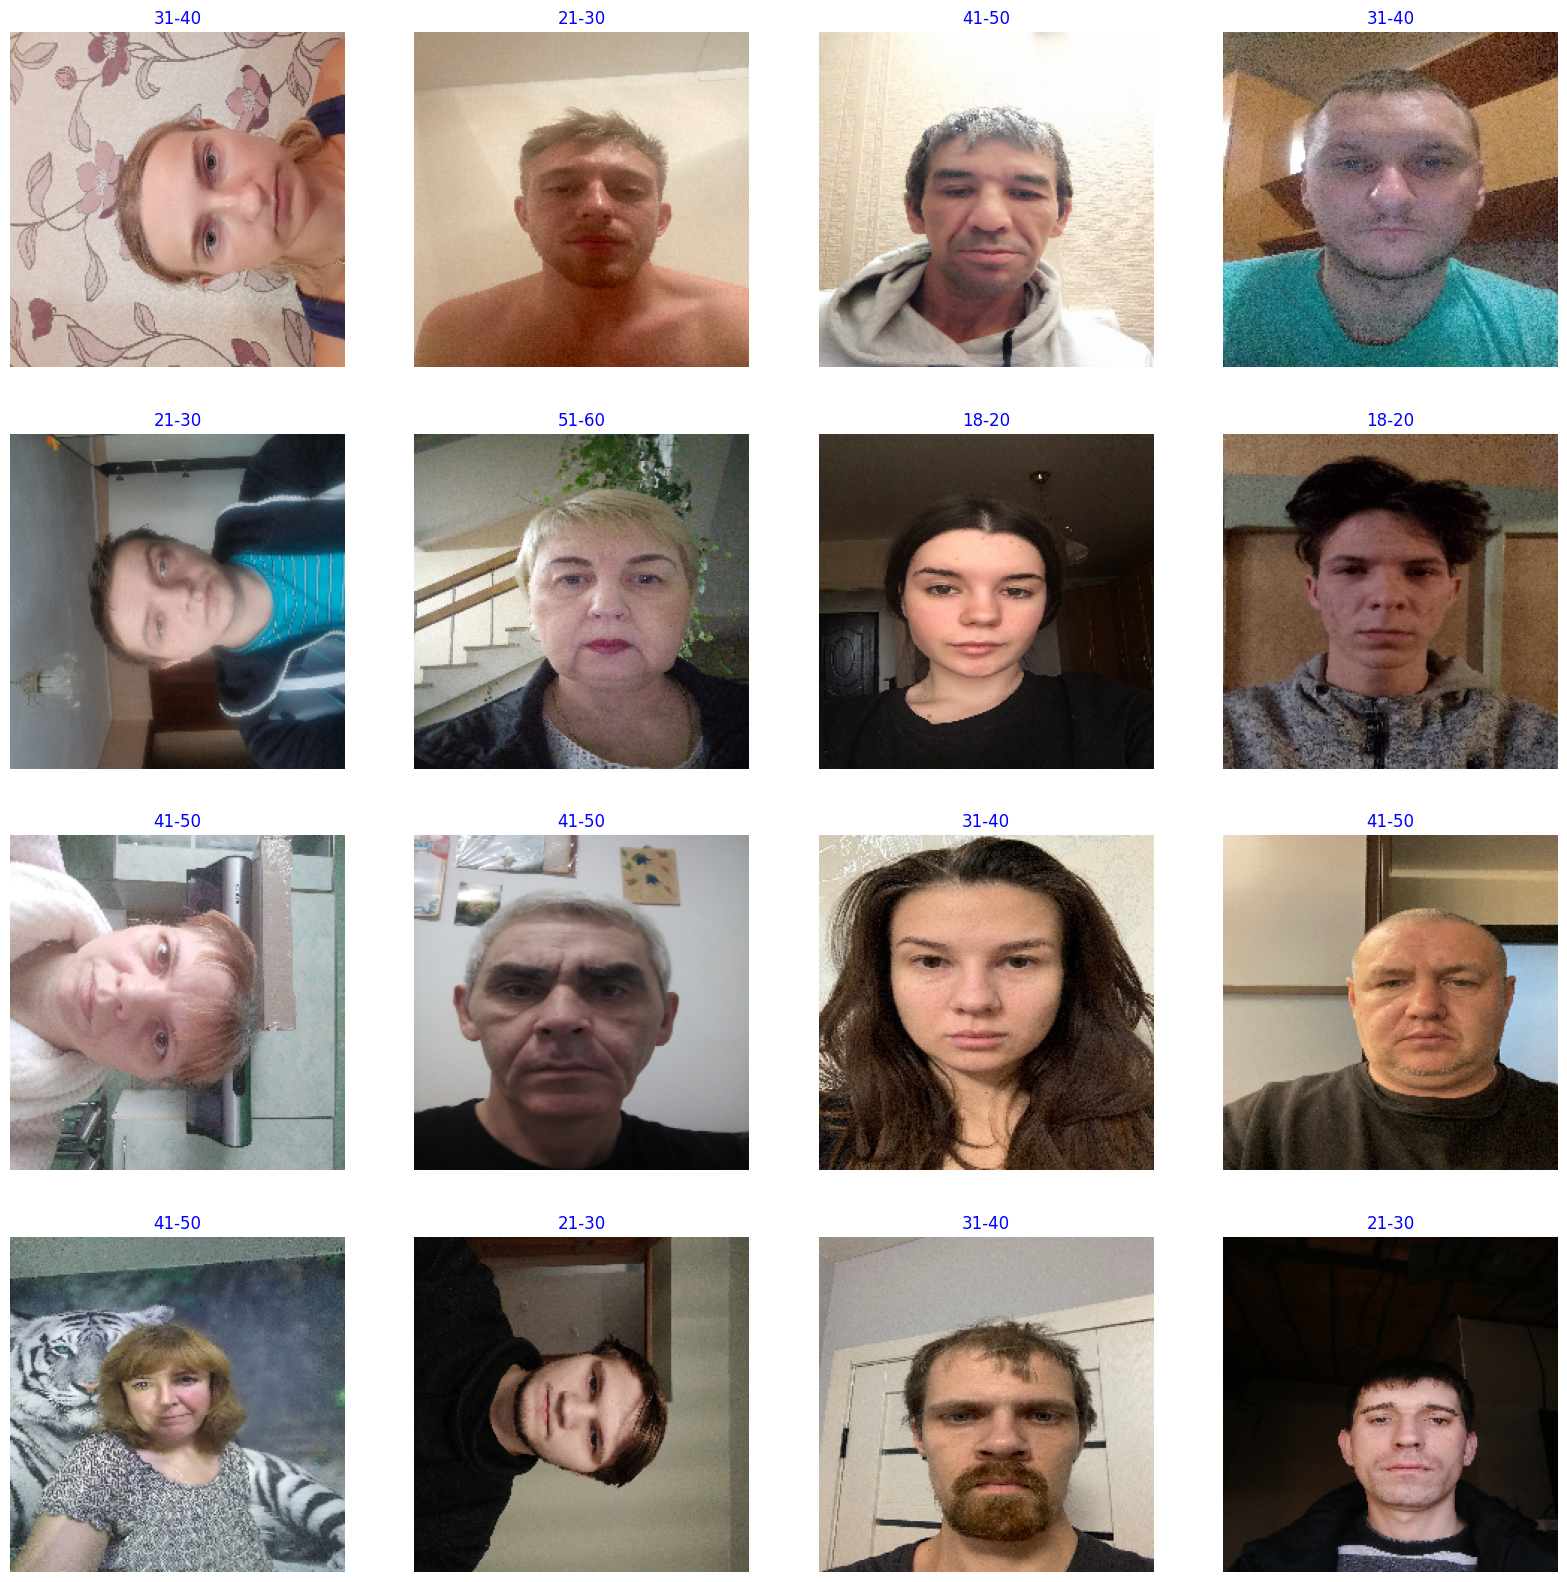

In [22]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

# **EfficientNet Model**

In [11]:
img_shape = (img_size[0],img_size[1],3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [12]:
epochs = 20
history = model.fit(x= train_gen , epochs = epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726812943.416812     155 service.cc:145] XLA service 0x7ec424002560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726812943.416873     155 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726813048.597490     155 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 288s 17s/step - accuracy: 0.2124 - loss: 21.6526 - val_accuracy: 0.2500 - val_loss: 27.9080
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4969 - loss: 19.9420 - val_accuracy: 0.3333 - val_loss: 25.0665
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7599 - loss: 17.8969 - val_accuracy: 0.3333 - val_loss: 23.1102
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8371 - loss: 16.1683 - val_accuracy: 0.3333 - val_loss: 20.0699
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8738 - loss: 14.0518 - val_accuracy: 0.2500 - val_loss: 18.3643
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8447 - loss: 12.1474 - val_accuracy: 0.2500 - val_loss: 18.3396
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7825 - loss: 10.5855 - val_accuracy: 0.1667 - val_loss: 15.8433
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6853 - loss: 9.4921 - val_accuracy: 0.2500 - val_loss: 14.8368
Ep

# **Model Performance**

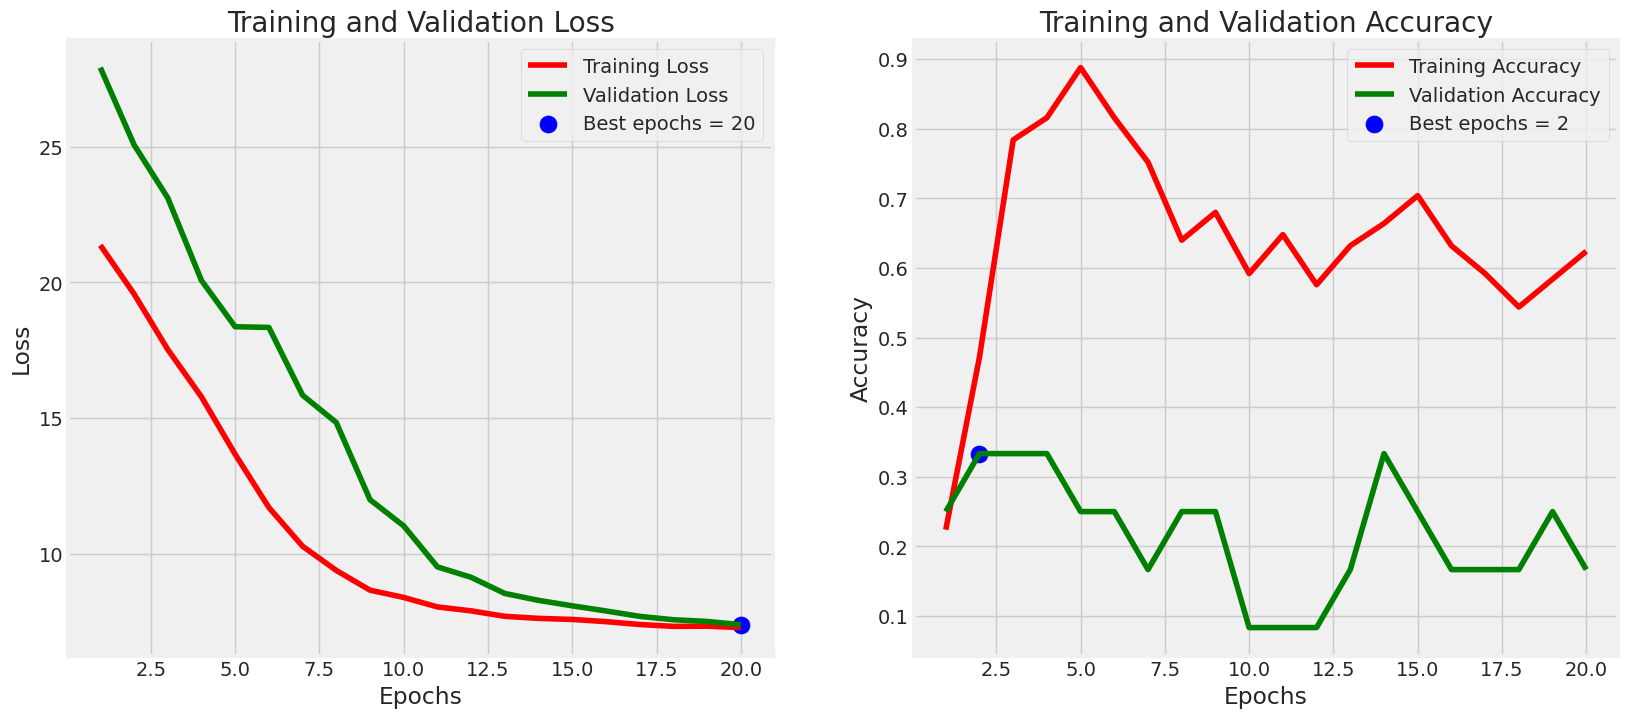

In [15]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# **Model Evaluation**

In [16]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 791ms/step - accuracy: 0.8250 - loss: 7.4636


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.1667 - loss: 7.3918


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - accuracy: 0.2308 - loss: 7.3221 
Train Loss:  7.4392242431640625
Train Accuracy:  0.8320000171661377
--------------------
Validation Loss:  7.391839504241943
Validation Accuracy:  0.1666666716337204
--------------------
Test Loss:  7.322072505950928
Test Accuracy:  0.23076923191547394


In [19]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


In [20]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

       18-20       0.67      0.67      0.67         3
       21-30       0.00      0.00      0.00         3
       31-40       0.50      1.00      0.67         1
       41-50       0.00      0.00      0.00         2
       51-60       0.00      0.00      0.00         4

    accuracy                           0.23        13
   macro avg       0.23      0.33      0.27        13
weighted avg       0.19      0.23      0.21        13



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[2, 0, 1, 0, 0],
       [0, 0, 0, 3, 0],
       [0, 0, 1, 0, 0],
       [0, 2, 0, 0, 0],
       [1, 2, 0, 1, 0]])

# **VGG16 Model**

In [32]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the VGG16 model pre-trained on ImageNet
vgg = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers in the pre-trained model
for layer in vgg.layers:
    layer.trainable = False

# Add custom layers for age prediction
x = Flatten()(vgg.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

# Create the model
vgg_model = Model(vgg.input, output)

# Compile the model
vgg_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,372,560 (127.31 MB)

 Trainable params: 11,094,061 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

 Optimizer params: 22,188,124 (84.64 MB)

In [33]:
# Train the model
history_vgg = vgg_model.fit(x= train_gen , epochs = 13 , verbose = 1 , validation_data = valid_gen)

Epoch 1/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 713ms/step - accuracy: 0.1501 - loss: 41.5614 - val_accuracy: 0.1667 - val_loss: 23.0905
Epoch 2/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.5651 - loss: 15.7873 - val_accuracy: 0.2500 - val_loss: 22.9052
Epoch 3/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.7052 - loss: 7.0531 - val_accuracy: 0.1667 - val_loss: 19.1317
Epoch 4/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.8182 - loss: 3.7069 - val_accuracy: 0.2500 - val_loss: 9.6692
Epoch 5/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.8270 - loss: 2.9381 - val_accuracy: 0.3333 - val_loss: 6.6897
Epoch 6/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.8607 - loss: 2.4613 - val_accuracy: 0.2500 - val_loss: 5.4740
Epoch 7/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.8029 - loss: 1.3236 - val_accuracy: 0.2500 - val_loss: 4.6239
Epoch 8/13
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.8276 - loss: 0.8212 - val_accuracy: 0.166

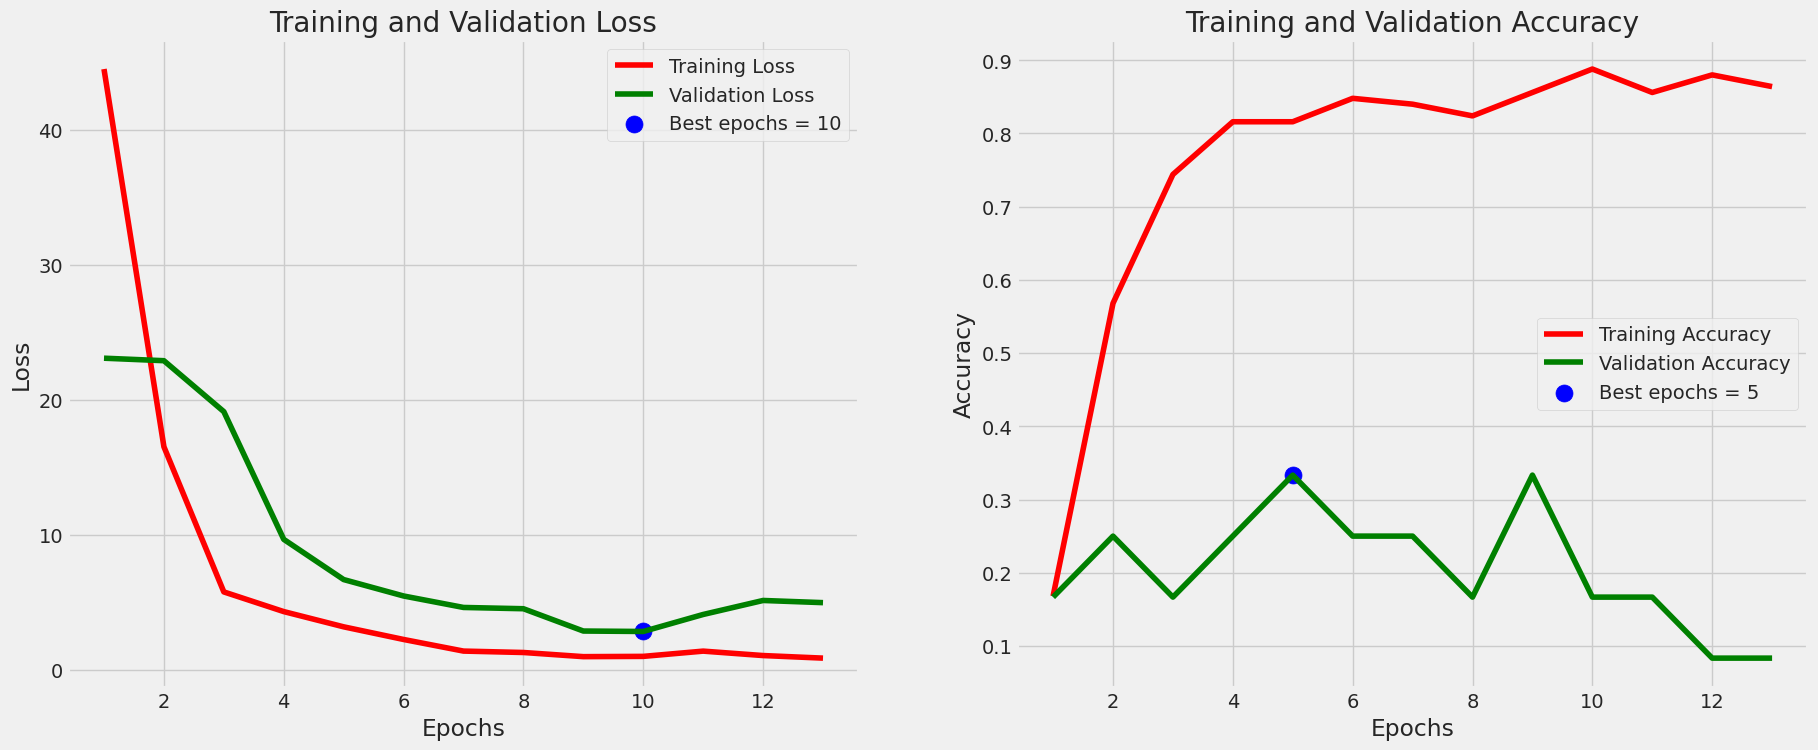

In [34]:
train_acc = history_vgg.history['accuracy']
train_loss = history_vgg.history['loss']

val_acc = history_vgg.history['val_accuracy']
val_loss = history_vgg.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [35]:
train_score = vgg_model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = vgg_model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = vgg_model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - accuracy: 1.0000 - loss: 0.0234


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - accuracy: 0.0833 - loss: 4.9803
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - accuracy: 0.3077 - loss: 5.2373 
Train Loss:  0.022383475676178932
Train Accuracy:  1.0
--------------------
Validation Loss:  4.980336666107178
Validation Accuracy:  0.0833333358168602
--------------------
Test Loss:  5.237259864807129
Test Accuracy:  0.3076923191547394


In [36]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


In [37]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

       18-20       0.67      0.67      0.67         3
       21-30       0.00      0.00      0.00         3
       31-40       0.50      1.00      0.67         1
       41-50       0.00      0.00      0.00         2
       51-60       0.00      0.00      0.00         4

    accuracy                           0.23        13
   macro avg       0.23      0.33      0.27        13
weighted avg       0.19      0.23      0.21        13



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[2, 0, 1, 0, 0],
       [0, 0, 0, 3, 0],
       [0, 0, 1, 0, 0],
       [0, 2, 0, 0, 0],
       [1, 2, 0, 1, 0]])

# **Resnet Model**

In [40]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model pre-trained on ImageNet
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)

# Freeze the layers in the pre-trained model
for layer in resnet.layers:
    layer.trainable = False

# Add custom layers for age prediction
x = Flatten()(resnet.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)

# Create the model
resnet_model = Model(resnet.input, output)

# Compile the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 250,  │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 122,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 122,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 122,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 124,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 61,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 61,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 61,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 61,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 61,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 61,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 61,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 61,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 61,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 61,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 61,    │      1,024 │ conv2_block1_3_c

 Total params: 38,268,549 (145.98 MB)

 Trainable params: 14,680,837 (56.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [42]:
# Train the model
history_resnet = resnet_model.fit(x= train_gen , epochs = 20 , verbose = 1 , validation_data = valid_gen)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 352ms/step - accuracy: 0.6175 - loss: 0.7802 - val_accuracy: 0.0833 - val_loss: 2.4155
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.6252 - loss: 0.8086 - val_accuracy: 0.0833 - val_loss: 2.3898
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.6530 - loss: 0.7121 - val_accuracy: 0.0833 - val_loss: 2.4569
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.7200 - loss: 0.7045 - val_accuracy: 0.0833 - val_loss: 2.4550
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.7227 - loss: 0.5371 - val_accuracy: 0.0833 - val_loss: 2.5138
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.7163 - loss: 0.6993 - val_accuracy: 0.0833 - val_loss: 2.9899
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.7450 - loss: 0.6344 - val_accuracy: 0.0833 - val_loss: 3.1521
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - accuracy: 0.6259 - loss: 0.6344 - val_accuracy: 0.1667 - v

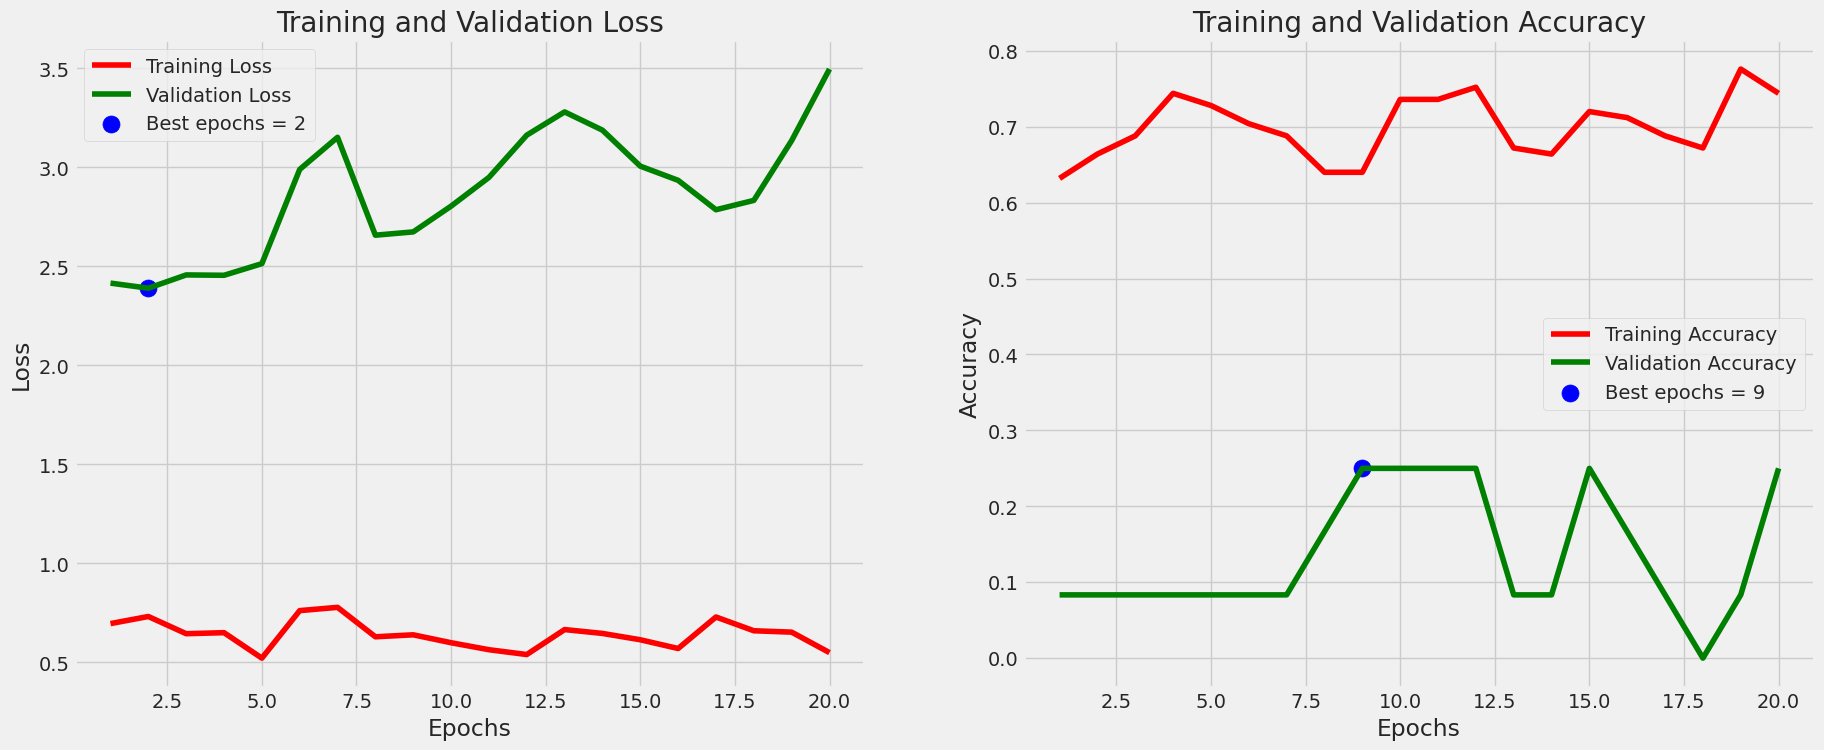

In [43]:
train_acc = history_resnet.history['accuracy']
train_loss = history_resnet.history['loss']

val_acc = history_resnet.history['val_accuracy']
val_loss = history_resnet.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [44]:
train_score = resnet_model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = resnet_model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = resnet_model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 616ms/step - accuracy: 0.9569 - loss: 0.1189


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.2500 - loss: 3.4970
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.3077 - loss: 1.4405 
Train Loss:  0.1101316437125206
Train Accuracy:  0.9679999947547913
--------------------
Validation Loss:  3.4969780445098877
Validation Accuracy:  0.25
--------------------
Test Loss:  1.4404512643814087
Test Accuracy:  0.3076923191547394


In [45]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


In [46]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

       18-20       0.67      0.67      0.67         3
       21-30       0.00      0.00      0.00         3
       31-40       0.50      1.00      0.67         1
       41-50       0.00      0.00      0.00         2
       51-60       0.00      0.00      0.00         4

    accuracy                           0.23        13
   macro avg       0.23      0.33      0.27        13
weighted avg       0.19      0.23      0.21        13



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[2, 0, 1, 0, 0],
       [0, 0, 0, 3, 0],
       [0, 0, 1, 0, 0],
       [0, 2, 0, 0, 0],
       [1, 2, 0, 1, 0]])

# **Inception-v3 Model**

In [23]:
img_shape = (224,224,3)

In [24]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the model
def build_inceptionv3(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Parameters
num_classes = 5

# Instantiate and compile model
model = build_inceptionv3(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,813,029 (83.21 MB)

 Trainable params: 21,778,597 (83.08 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [25]:
history = model.fit(x= train_gen , epochs = 20 , verbose = 1 , validation_data = valid_gen)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726836969.929106     103 service.cc:145] XLA service 0x7a7f54004f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726836969.929153     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/8 ━━━━━━━━━━━━━━━━━━━━ 8:57 77s/step - accuracy: 0.1250 - loss: 1.9810

I0000 00:00:1726837001.285044     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.2047 - loss: 1.9720 - val_accuracy: 0.1667 - val_loss: 2.0787
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - accuracy: 0.4851 - loss: 1.2637 - val_accuracy: 0.2500 - val_loss: 4.7144
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.8663 - loss: 0.4279 - val_accuracy: 0.0833 - val_loss: 11.9712
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.9747 - loss: 0.1600 - val_accuracy: 0.1667 - val_loss: 12.0626
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.8961 - loss: 0.4178 - val_accuracy: 0.1667 - val_loss: 16.6120
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.9114 - loss: 0.2668 - val_accuracy: 0.0833 - val_loss: 8.3689
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.8899 - loss: 0.2862 - val_accuracy: 0.2500 - val_loss: 5.7157
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - accuracy: 0.8307 - loss: 0.4381 - val_accuracy: 0.1667 - val_loss: 1

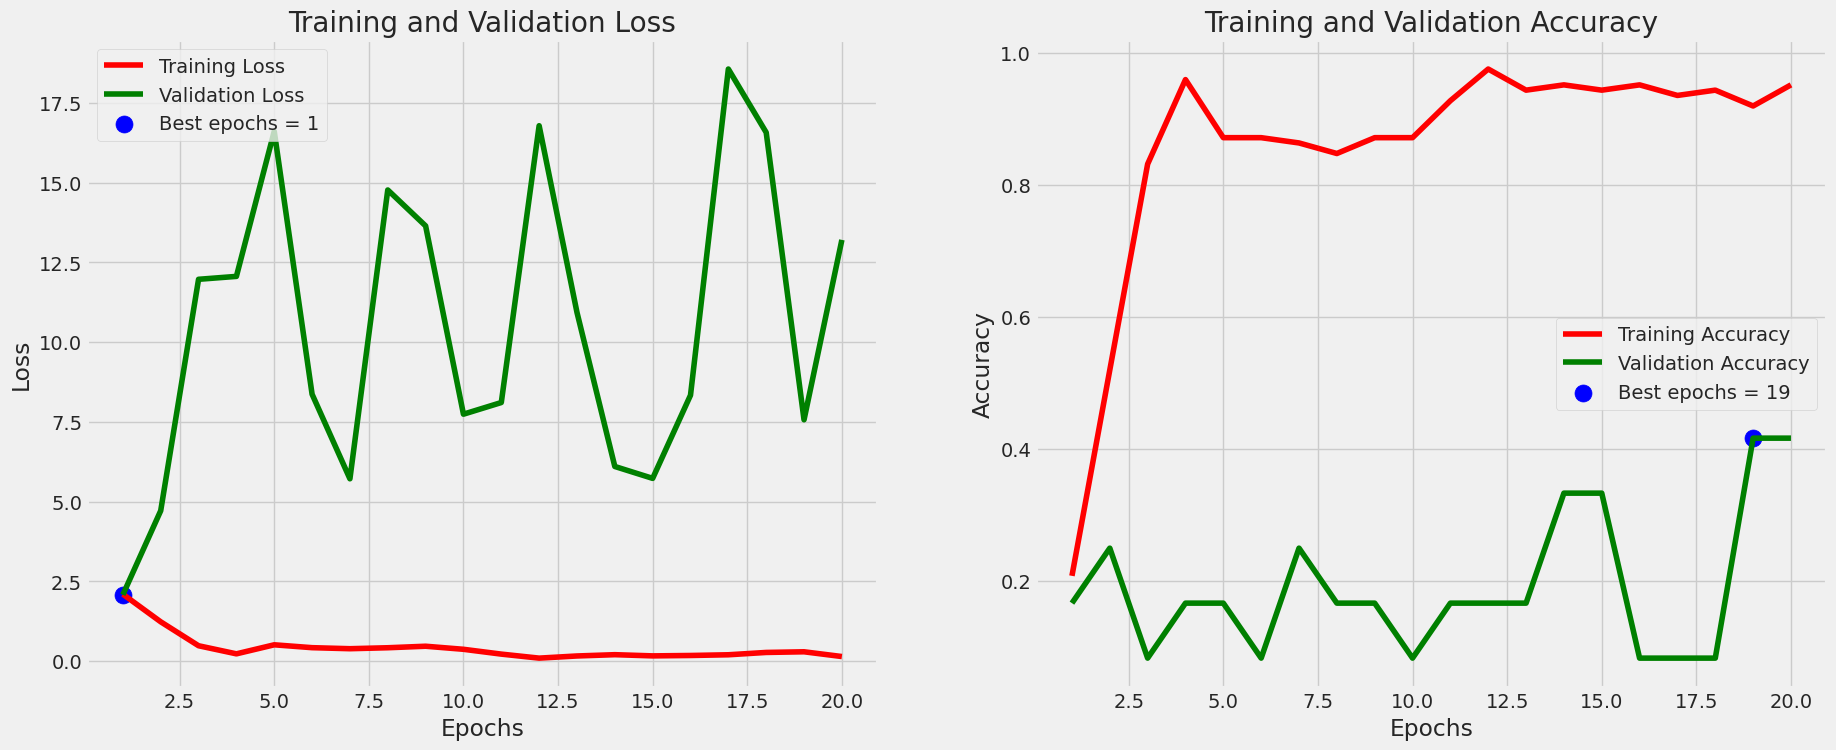

In [27]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [28]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 604ms/step - accuracy: 0.3826 - loss: 11.2467


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.4167 - loss: 13.2076


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.1538 - loss: 29.0314 
Train Loss:  11.884000778198242
Train Accuracy:  0.36800000071525574
--------------------
Validation Loss:  13.207629203796387
Validation Accuracy:  0.4166666567325592
--------------------
Test Loss:  29.03144645690918
Test Accuracy:  0.1538461595773697


In [29]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [30]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

       18-20       0.00      0.00      0.00         3
       21-30       0.33      0.33      0.33         3
       31-40       0.00      0.00      0.00         1
       41-50       0.11      0.50      0.18         2
       51-60       0.00      0.00      0.00         4

    accuracy                           0.15        13
   macro avg       0.09      0.17      0.10        13
weighted avg       0.09      0.15      0.10        13



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[0, 1, 0, 2, 0],
       [1, 1, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 0, 4, 0]])

# **MobileNet Model**

In [32]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the model
def build_mobilenet(num_classes):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=img_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

num_classes = 5

# Instantiate and compile model
model = build_mobilenet(num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,233,989 (12.34 MB)

 Trainable params: 3,212,101 (12.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [33]:
history = model.fit(x= train_gen , epochs = 20 , verbose = 1 , validation_data = valid_gen)

Epoch 1/20
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1181 - loss: 1.9271 

I0000 00:00:1726837763.288817     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_27', 4 bytes spill stores, 4 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.1634 - loss: 2.1471 - val_accuracy: 0.1667 - val_loss: 7.7394
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.9370 - loss: 0.2183 - val_accuracy: 0.1667 - val_loss: 7.9995
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.9291 - loss: 0.1477 - val_accuracy: 0.0833 - val_loss: 4.4347
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.9427 - loss: 0.1954 - val_accuracy: 0.2500 - val_loss: 5.2001
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.9831 - loss: 0.0703 - val_accuracy: 0.1667 - val_loss: 6.1534
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9902 - loss: 0.0252 - val_accuracy: 0.0833 - val_loss: 7.9355
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 0.1667 - val_loss: 10.1131
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9946 - loss: 0.0199 - val_accuracy: 0.1667 - val_loss: 10.0

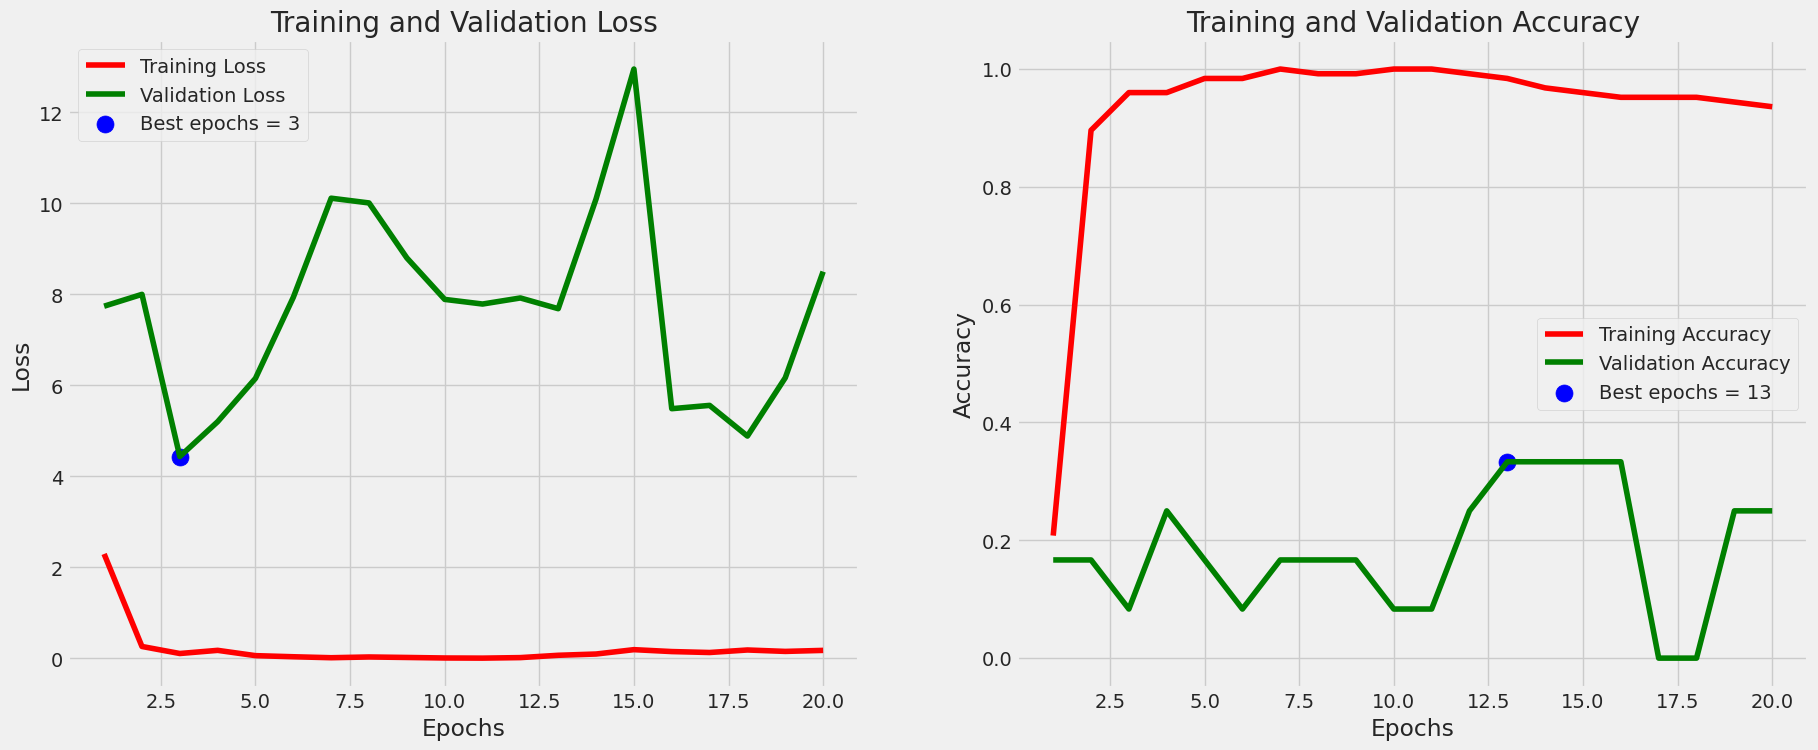

In [34]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [35]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 511ms/step - accuracy: 0.7304 - loss: 1.9164


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - accuracy: 0.2500 - loss: 8.4995 
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.3077 - loss: 10.0532 
Train Loss:  1.8707702159881592
Train Accuracy:  0.7440000176429749
--------------------
Validation Loss:  8.499517440795898
Validation Accuracy:  0.25
--------------------
Test Loss:  10.05318546295166
Test Accuracy:  0.3076923191547394


In [36]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [37]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

       18-20       0.00      0.00      0.00         3
       21-30       0.25      0.67      0.36         3
       31-40       0.00      0.00      0.00         1
       41-50       0.00      0.00      0.00         2
       51-60       0.50      0.50      0.50         4

    accuracy                           0.31        13
   macro avg       0.15      0.23      0.17        13
weighted avg       0.21      0.31      0.24        13



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[0, 3, 0, 0, 0],
       [0, 2, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 2, 0, 0, 2]])

# **CNN Model**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, InputLayer

model = Sequential()

# Input layer
model.add(InputLayer(shape=(224,224,3)))

# Convolutional layers and pooling
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer
model.add(Dropout(0.25))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 108, 108, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 106, 106, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 51, 51, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 49, 49, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,053,765 (118.46 MB)

 Trainable params: 31,053,765 (118.46 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [17]:
history = model.fit(x= train_gen , epochs = 100 , verbose = 1 , validation_data = valid_gen, callbacks=[early_stop])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.1956 - loss: 30.6587 - val_accuracy: 0.3333 - val_loss: 1.5933
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.1203 - loss: 1.6818 - val_accuracy: 0.0833 - val_loss: 1.6168
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.1642 - loss: 1.6116 - val_accuracy: 0.1667 - val_loss: 1.6119
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.2091 - loss: 1.6122 - val_accuracy: 0.1667 - val_loss: 1.6122
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 0.2021 - loss: 1.6118 - val_accuracy: 0.1667 - val_loss: 1.6125
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.1879 - loss: 1.6110 - val_accuracy: 0.1667 - val_loss: 1.6125


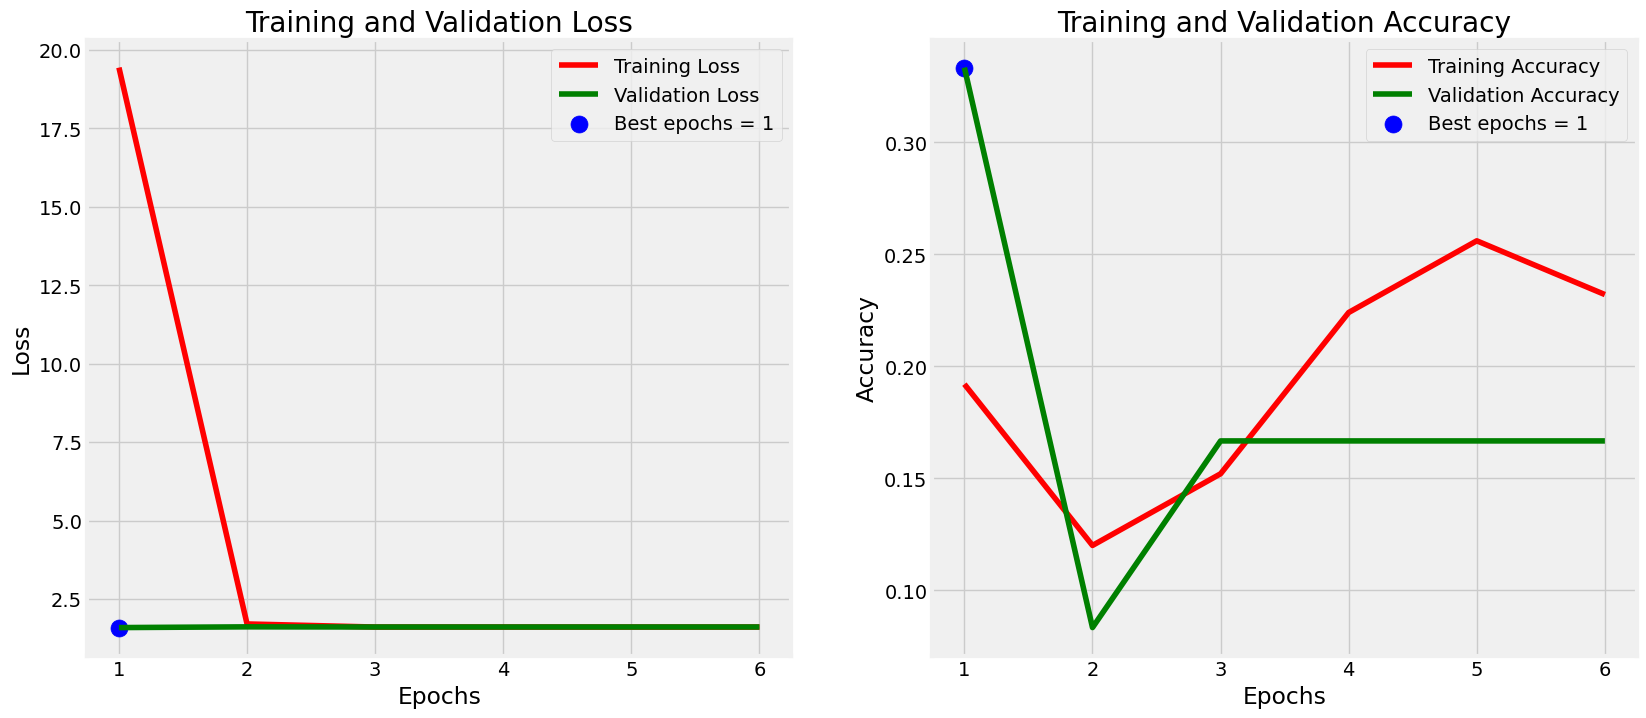

In [18]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [19]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 492ms/step - accuracy: 0.1820 - loss: 1.6097


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 468us/step - accuracy: 0.1667 - loss: 1.6125


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - accuracy: 0.2308 - loss: 1.6068 
Train Loss:  1.6095291376113892
Train Accuracy:  0.20000000298023224
--------------------
Validation Loss:  1.612466812133789
Validation Accuracy:  0.1666666716337204
--------------------
Test Loss:  1.6068183183670044
Test Accuracy:  0.23076923191547394


In [20]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [22]:
#Classification Report
print(classification_report(test_gen.classes, y_pred ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.23      1.00      0.38         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         4

    accuracy                           0.23        13
   macro avg       0.05      0.20      0.07        13
weighted avg       0.05      0.23      0.09        13



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

array([[0, 3, 0, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [0, 4, 0, 0, 0]])